# Experiment Efficiency Analysis

This notebook analyzes the efficiency metrics from existing experiment runs in the `experiments/` folder. Each experiment contains both accuracy results and comprehensive efficiency reports generated during model training and inference.

## Experiment Overview
- **Chronos Experiments**: Trained inference on OhioT1DM dataset (denoised and noisy)
- **TimeLLM Experiments**: Training and inference on OhioT1DM dataset (denoised and noisy)
- **Models**: Chronos-T5-Base, TimeLLM variants
- **Seeds**: Multiple seeds per experiment for statistical robustness
- **Patients**: 12 different patients for cross-patient validation

## 1. Import Required Libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from pathlib import Path
import warnings
from scipy import stats
import glob

# Configure display and plotting
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

print("Libraries imported successfully!")
print(f"Working directory: {os.getcwd()}")

Libraries imported successfully!
Working directory: /home/amma/LLM-TIME/notebooks


## 2. Discover and Load All Experiment Data

In [10]:
# Define experiments directory
experiments_dir = Path("/home/amma/LLM-TIME/experiments")
print(f"Scanning experiments directory: {experiments_dir}")
print("=" * 60)

# Find all experiment folders
experiment_folders = []
for item in experiments_dir.iterdir():
    if item.is_dir() and not item.name.endswith('.zip'):
        experiment_folders.append(item)
        print(f"📁 Found experiment: {item.name}")

print(f"\n📊 Total experiment folders found: {len(experiment_folders)}")

# Initialize data storage
experiment_summary = []
all_accuracy_data = []
all_efficiency_data = []

print("\n🔍 Analyzing experiment structure...")

Scanning experiments directory: /home/amma/LLM-TIME/experiments
📁 Found experiment: chronos_trained_inference_ohiot1dm_noisy
📁 Found experiment: time_llm_training_inference_ohiot1dm_train_standardized_test_denoised
📁 Found experiment: chronos_trained_inference_ohiot1dm_denoised
📁 Found experiment: time_llm_training_inference_ohiot1dm_train_standardized_test_noisy

📊 Total experiment folders found: 4

🔍 Analyzing experiment structure...


## 3. Load Accuracy Results from All Experiments

In [11]:
def load_experiment_accuracy_data(experiment_path):
    """Load accuracy data from an experiment folder."""
    experiment_name = experiment_path.name
    
    # Look for experiment_results.csv in nested structure
    nested_path = experiment_path / experiment_name
    results_file = nested_path / "experiment_results.csv"
    
    if results_file.exists():
        df = pd.read_csv(results_file)
        df['experiment_name'] = experiment_name
        return df
    else:
        print(f"⚠️  No experiment_results.csv found in {experiment_name}")
        return None

# Load accuracy data from all experiments
print("📈 Loading accuracy results from all experiments...")

for exp_folder in experiment_folders:
    accuracy_data = load_experiment_accuracy_data(exp_folder)
    if accuracy_data is not None:
        all_accuracy_data.append(accuracy_data)
        print(f"  ✅ {exp_folder.name}: {len(accuracy_data)} records")
    else:
        print(f"  ❌ {exp_folder.name}: No data found")

# Combine all accuracy data
if all_accuracy_data:
    combined_accuracy_df = pd.concat(all_accuracy_data, ignore_index=True)
    print(f"\n📊 Combined accuracy dataset: {len(combined_accuracy_df)} total records")
    print(f"   Experiments: {combined_accuracy_df['experiment_name'].nunique()}")
    print(f"   Models: {combined_accuracy_df['model'].nunique()}")
    print(f"   Patients: {combined_accuracy_df['patient_id'].nunique()}")
    print(f"   Seeds: {combined_accuracy_df['seed'].nunique()}")
else:
    print("❌ No accuracy data found in any experiment!")
    combined_accuracy_df = pd.DataFrame()

📈 Loading accuracy results from all experiments...
  ✅ chronos_trained_inference_ohiot1dm_noisy: 125 records
⚠️  No experiment_results.csv found in time_llm_training_inference_ohiot1dm_train_standardized_test_denoised
  ❌ time_llm_training_inference_ohiot1dm_train_standardized_test_denoised: No data found
  ✅ chronos_trained_inference_ohiot1dm_denoised: 60 records
⚠️  No experiment_results.csv found in time_llm_training_inference_ohiot1dm_train_standardized_test_noisy
  ❌ time_llm_training_inference_ohiot1dm_train_standardized_test_noisy: No data found

📊 Combined accuracy dataset: 185 total records
   Experiments: 2
   Models: 1
   Patients: 12
   Seeds: 5


## 4. Load Efficiency Reports from All Experiments

In [12]:
def find_efficiency_reports(experiment_path):
    """Find all efficiency reports in an experiment folder."""
    experiment_name = experiment_path.name
    reports = []
    
    # Look for efficiency reports in nested structure
    nested_path = experiment_path / experiment_name
    
    if not nested_path.exists():
        return reports
    
    # Search for JSON files with efficiency/performance keywords
    for json_file in nested_path.rglob("*.json"):
        if any(keyword in json_file.name.lower() for keyword in 
               ['efficiency_report', 'performance_report', 'comprehensive_performance']):
            try:
                with open(json_file, 'r') as f:
                    report_data = json.load(f)
                    report_data['file_path'] = str(json_file)
                    report_data['experiment_name'] = experiment_name
                    report_data['report_type'] = json_file.name
                    
                    # Extract patient ID from path
                    path_parts = json_file.parts
                    patient_part = [p for p in path_parts if p.startswith('patient_')]
                    if patient_part:
                        report_data['patient_id'] = int(patient_part[0].replace('patient_', ''))
                    
                    # Extract seed from path
                    seed_part = [p for p in path_parts if p.startswith('seed_')]
                    if seed_part:
                        seed_str = seed_part[0].split('_')[1]
                        report_data['seed'] = int(seed_str)
                    
                    reports.append(report_data)
            except Exception as e:
                print(f"⚠️  Error loading {json_file}: {e}")
    
    return reports

# Load efficiency data from all experiments
print("⚡ Loading efficiency reports from all experiments...")

for exp_folder in experiment_folders:
    efficiency_reports = find_efficiency_reports(exp_folder)
    if efficiency_reports:
        all_efficiency_data.extend(efficiency_reports)
        print(f"  ✅ {exp_folder.name}: {len(efficiency_reports)} efficiency reports")
    else:
        print(f"  ❌ {exp_folder.name}: No efficiency reports found")

print(f"\n⚡ Total efficiency reports found: {len(all_efficiency_data)}")

# Categorize efficiency reports
efficiency_by_type = {}
for report in all_efficiency_data:
    report_type = report['report_type']
    if report_type not in efficiency_by_type:
        efficiency_by_type[report_type] = []
    efficiency_by_type[report_type].append(report)

print("\n📊 Efficiency reports by type:")
for report_type, reports in efficiency_by_type.items():
    print(f"  • {report_type}: {len(reports)} reports")

⚡ Loading efficiency reports from all experiments...
  ✅ chronos_trained_inference_ohiot1dm_noisy: 614 efficiency reports
  ✅ time_llm_training_inference_ohiot1dm_train_standardized_test_denoised: 342 efficiency reports
  ✅ chronos_trained_inference_ohiot1dm_denoised: 240 efficiency reports
  ✅ time_llm_training_inference_ohiot1dm_train_standardized_test_noisy: 300 efficiency reports

⚡ Total efficiency reports found: 1496

📊 Efficiency reports by type:
  • efficiency_report_chronos_2025-10-12_19-34-26.json: 1 reports
  • efficiency_report_chronos_latest.json: 242 reports
  • comprehensive_performance_report_chronos_comprehensive_2025-10-12_19-34-38.json: 1 reports
  • real_performance_report_chronos_2025-10-12_19-34-38.json: 1 reports
  • comprehensive_performance_report_chronos_comprehensive_2025-10-12_19-53-12.json: 1 reports
  • efficiency_report_chronos_2025-10-12_19-53-00.json: 1 reports
  • real_performance_report_chronos_2025-10-12_19-53-12.json: 1 reports
  • efficiency_report

## 5. Create Comprehensive Accuracy Analysis

In [13]:
if not combined_accuracy_df.empty:
    print("📈 ACCURACY ANALYSIS ACROSS ALL EXPERIMENTS")
    print("=" * 60)
    
    # Overall statistics
    print("\n📊 Overall Accuracy Statistics:")
    accuracy_stats = combined_accuracy_df[['rmse', 'mae', 'mape']].describe()
    print(accuracy_stats.round(4))
    
    # By experiment analysis
    print("\n🧪 Performance by Experiment:")
    exp_summary = combined_accuracy_df.groupby('experiment_name').agg({
        'rmse': ['mean', 'std', 'count'],
        'mae': ['mean', 'std'],
        'mape': ['mean', 'std'],
        'patient_id': 'nunique',
        'seed': 'nunique'
    }).round(4)
    
    exp_summary.columns = ['_'.join(col).strip() for col in exp_summary.columns]
    print(exp_summary)
    
    # By model analysis
    print("\n🤖 Performance by Model:")
    model_summary = combined_accuracy_df.groupby('model').agg({
        'rmse': ['mean', 'std', 'count'],
        'mae': ['mean', 'std'],
        'mape': ['mean', 'std']
    }).round(4)
    
    model_summary.columns = ['_'.join(col).strip() for col in model_summary.columns]
    print(model_summary)
    
    # Data quality analysis
    print("\n🔍 Data Quality Analysis:")
    if 'denoised' in combined_accuracy_df['experiment_name'].iloc[0]:
        denoised_data = combined_accuracy_df[combined_accuracy_df['experiment_name'].str.contains('denoised')]
        noisy_data = combined_accuracy_df[combined_accuracy_df['experiment_name'].str.contains('noisy')]
        
        if len(denoised_data) > 0 and len(noisy_data) > 0:
            print(f"\nDenoised Data (n={len(denoised_data)}):")
            print(f"  RMSE: {denoised_data['rmse'].mean():.4f} ± {denoised_data['rmse'].std():.4f}")
            print(f"  MAE:  {denoised_data['mae'].mean():.4f} ± {denoised_data['mae'].std():.4f}")
            
            print(f"\nNoisy Data (n={len(noisy_data)}):")
            print(f"  RMSE: {noisy_data['rmse'].mean():.4f} ± {noisy_data['rmse'].std():.4f}")
            print(f"  MAE:  {noisy_data['mae'].mean():.4f} ± {noisy_data['mae'].std():.4f}")
            
            # Statistical test
            t_stat, p_val = stats.ttest_ind(denoised_data['rmse'], noisy_data['rmse'])
            print(f"\nStatistical Test (Denoised vs Noisy RMSE):")
            print(f"  t-statistic: {t_stat:.4f}")
            print(f"  p-value: {p_val:.4f}")
            print(f"  Significant difference: {'Yes' if p_val < 0.05 else 'No'}")
else:
    print("❌ No accuracy data available for analysis")

📈 ACCURACY ANALYSIS ACROSS ALL EXPERIMENTS

📊 Overall Accuracy Statistics:
           rmse       mae     mape
count  185.0000  185.0000  60.0000
mean    61.9211   28.2191   0.0711
std     31.7637   12.5120   0.0256
min     12.3725    7.8019   0.0408
25%     31.9175   11.1477   0.0572
50%     67.7227   34.6390   0.0620
75%     74.2857   36.7637   0.0789
max    179.3407   46.9758   0.1497

🧪 Performance by Experiment:
                                             rmse_mean  rmse_std  rmse_count  \
experiment_name                                                                
chronos_trained_inference_ohiot1dm_denoised    30.6543   24.3671          60   
chronos_trained_inference_ohiot1dm_noisy       76.9291   22.6831         125   

                                             mae_mean  mae_std  mape_mean  \
experiment_name                                                             
chronos_trained_inference_ohiot1dm_denoised   11.0618   3.3808     0.0711   
chronos_trained_inference_oh

## 6. Extract and Analyze Efficiency Metrics

In [14]:
def extract_efficiency_metrics(efficiency_reports):
    """Extract key efficiency metrics from reports."""
    efficiency_data = []
    
    for report in efficiency_reports:
        metrics = {
            'experiment_name': report.get('experiment_name', 'unknown'),
            'patient_id': report.get('patient_id', 0),
            'seed': report.get('seed', 0),
            'model_name': report.get('model_name', 'unknown'),
            'report_type': report.get('report_type', 'unknown'),
            'timestamp': report.get('timestamp', 'unknown')
        }
        
        # Extract model characteristics
        if 'model_characteristics' in report:
            char = report['model_characteristics']
            metrics['total_parameters'] = char.get('total_parameters', 0)
            metrics['model_size_mb'] = char.get('model_size_mb', 0)
            metrics['model_dtype'] = char.get('model_dtype', 'unknown')
        
        # Extract real performance measurements
        if 'real_performance_measurements' in report:
            perf = report['real_performance_measurements']
            
            # Timing metrics
            if 'inference_timing' in perf:
                timing = perf['inference_timing']
                metrics['avg_latency_ms'] = timing.get('average_latency_ms', 0)
                metrics['median_latency_ms'] = timing.get('median_latency_ms', 0)
                metrics['p95_latency_ms'] = timing.get('p95_latency_ms', 0)
                metrics['total_inferences'] = timing.get('total_inferences_measured', 0)
            
            # Memory metrics
            if 'memory_usage' in perf:
                memory = perf['memory_usage']
                metrics['peak_ram_mb'] = memory.get('process_peak_ram_mb', memory.get('peak_ram_mb', 0))
                metrics['avg_ram_mb'] = memory.get('process_average_ram_mb', memory.get('average_ram_mb', 0))
                metrics['system_peak_ram_mb'] = memory.get('system_peak_ram_mb', 0)
            
            # GPU metrics
            if 'gpu_memory_usage' in perf:
                gpu = perf['gpu_memory_usage']
                metrics['peak_gpu_mb'] = gpu.get('peak_allocated_mb', 0)
                metrics['avg_gpu_mb'] = gpu.get('average_allocated_mb', 0)
            
            # NVIDIA ML metrics
            if 'nvidia_ml_metrics' in perf:
                nvidia = perf['nvidia_ml_metrics']
                metrics['peak_gpu_util'] = nvidia.get('peak_gpu_utilization_percent', 0)
                metrics['avg_gpu_util'] = nvidia.get('average_gpu_utilization_percent', 0)
                metrics['peak_temp_c'] = nvidia.get('peak_temperature_celsius', 0)
                metrics['peak_power_w'] = nvidia.get('peak_power_usage_watts', 0)
                metrics['avg_power_w'] = nvidia.get('average_power_usage_watts', 0)
        
        # Edge deployment analysis
        if 'edge_deployment_analysis' in report:
            edge = report['edge_deployment_analysis']
            metrics['edge_feasibility'] = edge.get('feasibility_assessment', 'unknown')
            metrics['feasible_devices'] = len(edge.get('feasible_edge_devices', []))
        
        efficiency_data.append(metrics)
    
    return pd.DataFrame(efficiency_data)

# Extract efficiency metrics
if all_efficiency_data:
    print("⚡ EFFICIENCY ANALYSIS ACROSS ALL EXPERIMENTS")
    print("=" * 60)
    
    efficiency_df = extract_efficiency_metrics(all_efficiency_data)
    print(f"\n📊 Efficiency dataset: {len(efficiency_df)} records")
    print(f"   Experiments: {efficiency_df['experiment_name'].nunique()}")
    print(f"   Patients: {efficiency_df['patient_id'].nunique()}")
    print(f"   Seeds: {efficiency_df['seed'].nunique()}")
    print(f"   Report types: {efficiency_df['report_type'].nunique()}")
    
    # Filter for real performance reports (most comprehensive)
    real_perf_df = efficiency_df[efficiency_df['report_type'].str.contains('real_performance', na=False)]
    
    if not real_perf_df.empty:
        print(f"\n⚡ Real performance data: {len(real_perf_df)} records")
        
        # Overall efficiency statistics
        print("\n📈 Overall Efficiency Statistics:")
        efficiency_metrics = ['avg_latency_ms', 'peak_ram_mb', 'peak_gpu_mb', 'peak_gpu_util', 'peak_power_w']
        available_metrics = [col for col in efficiency_metrics if col in real_perf_df.columns]
        
        if available_metrics:
            eff_stats = real_perf_df[available_metrics].describe()
            print(eff_stats.round(2))
        
        # Efficiency by experiment
        print("\n🧪 Efficiency by Experiment:")
        exp_eff_summary = real_perf_df.groupby('experiment_name')[available_metrics].agg(['mean', 'std']).round(2)
        print(exp_eff_summary)
    else:
        print("❌ No real performance data found")
        real_perf_df = pd.DataFrame()
else:
    print("❌ No efficiency data available for analysis")
    efficiency_df = pd.DataFrame()
    real_perf_df = pd.DataFrame()

⚡ EFFICIENCY ANALYSIS ACROSS ALL EXPERIMENTS

📊 Efficiency dataset: 1496 records
   Experiments: 4
   Patients: 12
   Seeds: 5
   Report types: 1121

⚡ Real performance data: 433 records

📈 Overall Efficiency Statistics:
       avg_latency_ms  peak_ram_mb  peak_gpu_mb  peak_gpu_util  peak_power_w
count          433.00       433.00       433.00         433.00        433.00
mean        120248.50      1992.34      3266.76          51.15        212.31
std         170521.69       325.54      2526.83          14.51         65.39
min          10494.45      1584.06       902.63          33.00        125.68
25%          11434.49      1624.20      1212.94          36.00        144.06
50%          14672.05      2203.22      2007.32          54.00        229.51
75%         366206.68      2268.22      6735.40          70.00        291.13
max         449600.25      2746.79      7516.43          74.00        314.76

🧪 Efficiency by Experiment:
                                                   avg_la

## 7. Efficiency vs Accuracy Analysis

In [15]:
def merge_accuracy_efficiency_data():
    """Merge accuracy and efficiency data for joint analysis."""
    if combined_accuracy_df.empty or real_perf_df.empty:
        print("❌ Cannot merge: missing accuracy or efficiency data")
        return pd.DataFrame()
    
    # Merge on experiment, patient, and seed
    merged_df = pd.merge(
        combined_accuracy_df,
        real_perf_df,
        on=['experiment_name', 'patient_id', 'seed'],
        how='inner',
        suffixes=('_acc', '_eff')
    )
    
    return merged_df

# Create joint analysis
print("🔄 EFFICIENCY vs ACCURACY ANALYSIS")
print("=" * 50)

merged_data = merge_accuracy_efficiency_data()

if not merged_data.empty:
    print(f"\n✅ Successfully merged {len(merged_data)} records")
    print(f"   Experiments: {merged_data['experiment_name'].nunique()}")
    print(f"   Patients: {merged_data['patient_id'].nunique()}")
    print(f"   Seeds: {merged_data['seed'].nunique()}")
    
    # Calculate efficiency-accuracy ratios
    merged_data['efficiency_score'] = 1 / (merged_data['avg_latency_ms'] / 1000)  # Samples per second
    merged_data['accuracy_score'] = 1 / merged_data['rmse']  # Higher is better
    merged_data['efficiency_accuracy_ratio'] = merged_data['efficiency_score'] / merged_data['accuracy_score']
    
    # Performance trade-offs
    print("\n⚖️  Efficiency-Accuracy Trade-offs:")
    tradeoff_summary = merged_data.groupby('experiment_name').agg({
        'rmse': ['mean', 'std'],
        'avg_latency_ms': ['mean', 'std'],
        'peak_ram_mb': ['mean', 'std'],
        'efficiency_score': ['mean', 'std']
    }).round(3)
    
    tradeoff_summary.columns = ['_'.join(col).strip() for col in tradeoff_summary.columns]
    print(tradeoff_summary)
    
    # Correlation analysis
    print("\n📊 Correlation Analysis:")
    correlation_cols = ['rmse', 'mae', 'avg_latency_ms', 'peak_ram_mb', 'peak_gpu_mb']
    available_corr_cols = [col for col in correlation_cols if col in merged_data.columns]
    
    if len(available_corr_cols) >= 2:
        correlations = merged_data[available_corr_cols].corr()
        print(correlations.round(3))
    
else:
    print("❌ Could not merge accuracy and efficiency data")
    merged_data = pd.DataFrame()

🔄 EFFICIENCY vs ACCURACY ANALYSIS

✅ Successfully merged 325 records
   Experiments: 2
   Patients: 12
   Seeds: 5

⚖️  Efficiency-Accuracy Trade-offs:
                                             rmse_mean  rmse_std  \
experiment_name                                                    
chronos_trained_inference_ohiot1dm_denoised     30.654    24.367   
chronos_trained_inference_ohiot1dm_noisy        76.090    22.350   

                                             avg_latency_ms_mean  \
experiment_name                                                    
chronos_trained_inference_ohiot1dm_denoised            11401.045   
chronos_trained_inference_ohiot1dm_noisy               11379.546   

                                             avg_latency_ms_std  \
experiment_name                                                   
chronos_trained_inference_ohiot1dm_denoised             383.611   
chronos_trained_inference_ohiot1dm_noisy                441.402   

                                 

## 8. Create Comprehensive Visualizations

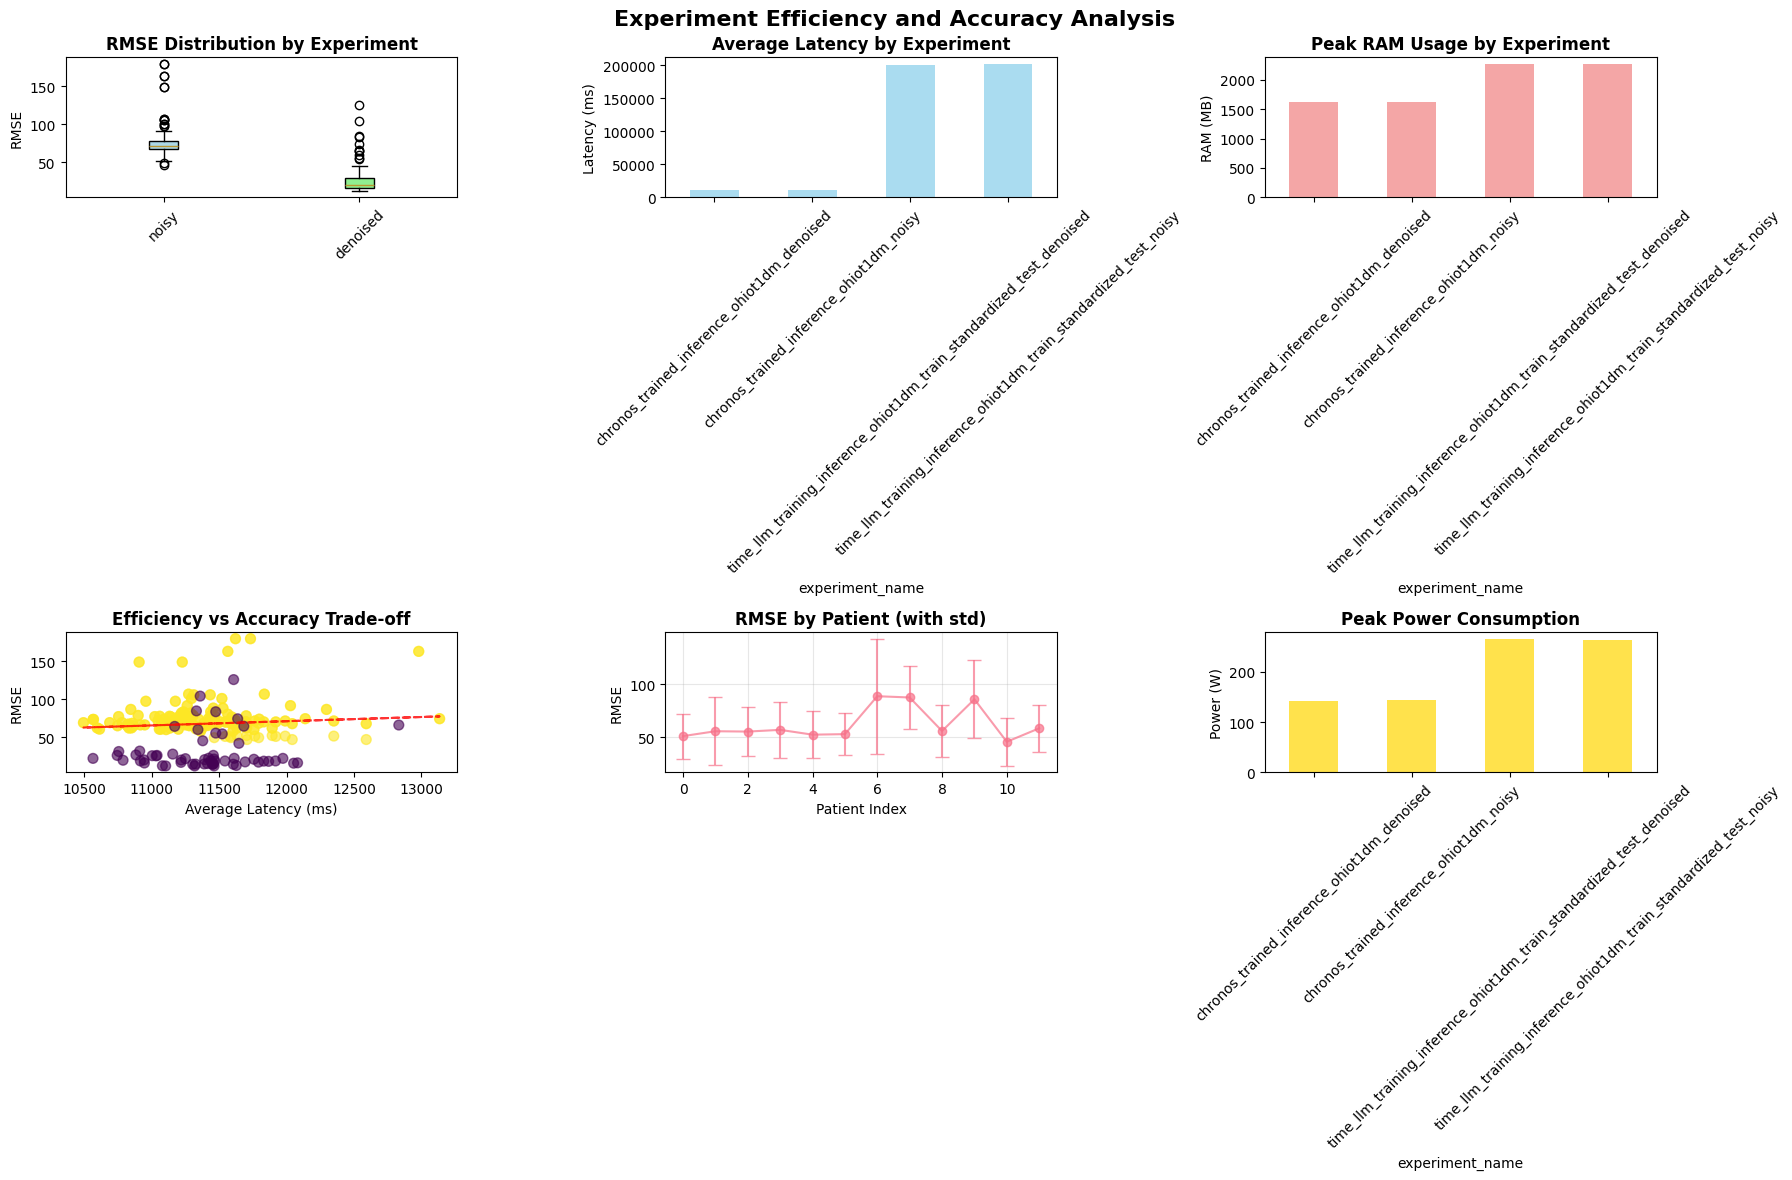

📊 Visualization plots saved to: /home/amma/LLM-TIME/notebooks/experiment_analysis_plots.png


In [16]:
# Create comprehensive visualization dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Experiment Efficiency and Accuracy Analysis', fontsize=16, fontweight='bold')

# 1. Accuracy comparison across experiments
if not combined_accuracy_df.empty:
    ax1 = axes[0, 0]
    exp_names = combined_accuracy_df['experiment_name'].unique()
    rmse_by_exp = [combined_accuracy_df[combined_accuracy_df['experiment_name'] == exp]['rmse'].values for exp in exp_names]
    
    bp1 = ax1.boxplot(rmse_by_exp, labels=[exp.split('_')[-1] for exp in exp_names], patch_artist=True)
    ax1.set_title('RMSE Distribution by Experiment', fontweight='bold')
    ax1.set_ylabel('RMSE')
    ax1.tick_params(axis='x', rotation=45)
    
    # Color boxes
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold']
    for patch, color in zip(bp1['boxes'], colors[:len(bp1['boxes'])]):
        patch.set_facecolor(color)

# 2. Efficiency metrics comparison
if not real_perf_df.empty and 'avg_latency_ms' in real_perf_df.columns:
    ax2 = axes[0, 1]
    exp_efficiency = real_perf_df.groupby('experiment_name')['avg_latency_ms'].mean()
    exp_efficiency.plot(kind='bar', ax=ax2, color='skyblue', alpha=0.7)
    ax2.set_title('Average Latency by Experiment', fontweight='bold')
    ax2.set_ylabel('Latency (ms)')
    ax2.tick_params(axis='x', rotation=45)

# 3. Memory usage comparison
if not real_perf_df.empty and 'peak_ram_mb' in real_perf_df.columns:
    ax3 = axes[0, 2]
    exp_memory = real_perf_df.groupby('experiment_name')['peak_ram_mb'].mean()
    exp_memory.plot(kind='bar', ax=ax3, color='lightcoral', alpha=0.7)
    ax3.set_title('Peak RAM Usage by Experiment', fontweight='bold')
    ax3.set_ylabel('RAM (MB)')
    ax3.tick_params(axis='x', rotation=45)

# 4. Efficiency vs Accuracy scatter plot
if not merged_data.empty:
    ax4 = axes[1, 0]
    scatter = ax4.scatter(merged_data['avg_latency_ms'], merged_data['rmse'], 
                         c=merged_data['experiment_name'].astype('category').cat.codes, 
                         alpha=0.6, s=50)
    ax4.set_xlabel('Average Latency (ms)')
    ax4.set_ylabel('RMSE')
    ax4.set_title('Efficiency vs Accuracy Trade-off', fontweight='bold')
    
    # Add trend line
    if len(merged_data) > 1:
        z = np.polyfit(merged_data['avg_latency_ms'], merged_data['rmse'], 1)
        p = np.poly1d(z)
        ax4.plot(merged_data['avg_latency_ms'], p(merged_data['avg_latency_ms']), "r--", alpha=0.8)

# 5. Patient performance variability
if not combined_accuracy_df.empty:
    ax5 = axes[1, 1]
    patient_rmse = combined_accuracy_df.groupby('patient_id')['rmse'].agg(['mean', 'std'])
    ax5.errorbar(range(len(patient_rmse)), patient_rmse['mean'], 
                yerr=patient_rmse['std'], fmt='o-', capsize=5, alpha=0.7)
    ax5.set_title('RMSE by Patient (with std)', fontweight='bold')
    ax5.set_xlabel('Patient Index')
    ax5.set_ylabel('RMSE')
    ax5.grid(True, alpha=0.3)

# 6. Power consumption analysis
if not real_perf_df.empty and 'peak_power_w' in real_perf_df.columns:
    power_data = real_perf_df.dropna(subset=['peak_power_w'])
    if not power_data.empty:
        ax6 = axes[1, 2]
        exp_power = power_data.groupby('experiment_name')['peak_power_w'].mean()
        exp_power.plot(kind='bar', ax=ax6, color='gold', alpha=0.7)
        ax6.set_title('Peak Power Consumption', fontweight='bold')
        ax6.set_ylabel('Power (W)')
        ax6.tick_params(axis='x', rotation=45)
    else:
        axes[1, 2].text(0.5, 0.5, 'No Power Data Available', 
                        transform=axes[1, 2].transAxes, ha='center', va='center')
else:
    axes[1, 2].text(0.5, 0.5, 'No Power Data Available', 
                    transform=axes[1, 2].transAxes, ha='center', va='center')

plt.tight_layout()
plt.savefig('/home/amma/LLM-TIME/notebooks/experiment_analysis_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Visualization plots saved to: /home/amma/LLM-TIME/notebooks/experiment_analysis_plots.png")

## 9. Generate Summary Tables for Paper

In [17]:
def create_paper_summary_tables():
    """Create summary tables suitable for research paper."""
    
    tables = {}
    
    # Table 1: Accuracy Summary by Experiment
    if not combined_accuracy_df.empty:
        accuracy_table = combined_accuracy_df.groupby('experiment_name').agg({
            'rmse': ['mean', 'std', 'count'],
            'mae': ['mean', 'std'],
            'mape': ['mean', 'std'],
            'patient_id': 'nunique',
            'seed': 'nunique'
        }).round(4)
        
        # Flatten column names
        accuracy_table.columns = ['_'.join(col).strip() for col in accuracy_table.columns]
        tables['accuracy_summary'] = accuracy_table
    
    # Table 2: Efficiency Summary by Experiment
    if not real_perf_df.empty:
        efficiency_metrics = ['avg_latency_ms', 'peak_ram_mb', 'peak_gpu_mb', 'peak_gpu_util', 'peak_power_w']
        available_eff_metrics = [col for col in efficiency_metrics if col in real_perf_df.columns]
        
        if available_eff_metrics:
            efficiency_table = real_perf_df.groupby('experiment_name')[available_eff_metrics].agg(['mean', 'std', 'count']).round(2)
            efficiency_table.columns = ['_'.join(col).strip() for col in efficiency_table.columns]
            tables['efficiency_summary'] = efficiency_table
    
    # Table 3: Combined Efficiency-Accuracy Summary
    if not merged_data.empty:
        combined_table = merged_data.groupby('experiment_name').agg({
            'rmse': ['mean', 'std'],
            'mae': ['mean', 'std'],
            'avg_latency_ms': ['mean', 'std'],
            'peak_ram_mb': ['mean', 'std'],
            'peak_gpu_mb': ['mean', 'std'],
            'patient_id': 'nunique'
        }).round(3)
        
        combined_table.columns = ['_'.join(col).strip() for col in combined_table.columns]
        tables['combined_summary'] = combined_table
    
    return tables

# Generate summary tables
print("📋 GENERATING SUMMARY TABLES FOR PAPER")
print("=" * 50)

summary_tables = create_paper_summary_tables()

for table_name, table_df in summary_tables.items():
    print(f"\n📊 {table_name.upper().replace('_', ' ')}:")
    print("=" * 60)
    print(table_df)
    
    # Save to CSV
    csv_path = f"/home/amma/LLM-TIME/notebooks/{table_name}_table.csv"
    table_df.to_csv(csv_path)
    print(f"💾 Saved to: {csv_path}")

# Generate LaTeX table for paper
if 'combined_summary' in summary_tables:
    latex_table = summary_tables['combined_summary'].to_latex(float_format="%.3f")
    latex_path = "/home/amma/LLM-TIME/notebooks/experiment_summary_table.tex"
    with open(latex_path, 'w') as f:
        f.write(latex_table)
    print(f"\n📄 LaTeX table saved to: {latex_path}")

📋 GENERATING SUMMARY TABLES FOR PAPER

📊 ACCURACY SUMMARY:
                                             rmse_mean  rmse_std  rmse_count  \
experiment_name                                                                
chronos_trained_inference_ohiot1dm_denoised    30.6543   24.3671          60   
chronos_trained_inference_ohiot1dm_noisy       76.9291   22.6831         125   

                                             mae_mean  mae_std  mape_mean  \
experiment_name                                                             
chronos_trained_inference_ohiot1dm_denoised   11.0618   3.3808     0.0711   
chronos_trained_inference_ohiot1dm_noisy      36.4546   4.0063        NaN   

                                             mape_std  patient_id_nunique  \
experiment_name                                                             
chronos_trained_inference_ohiot1dm_denoised    0.0256                  12   
chronos_trained_inference_ohiot1dm_noisy          NaN                  12   

  

## 10. Key Findings and Recommendations

In [18]:
print("🎯 KEY FINDINGS AND RECOMMENDATIONS")
print("=" * 60)

# Data availability summary
print("\n📊 DATA AVAILABILITY:")
print(f"  ✅ Accuracy data: {len(combined_accuracy_df) if not combined_accuracy_df.empty else 0} records")
print(f"  ⚡ Efficiency data: {len(real_perf_df) if not real_perf_df.empty else 0} records")
print(f"  🔄 Combined data: {len(merged_data) if not merged_data.empty else 0} records")

# Key insights
if not combined_accuracy_df.empty:
    print("\n🔍 ACCURACY INSIGHTS:")
    best_exp = combined_accuracy_df.groupby('experiment_name')['rmse'].mean().idxmin()
    best_rmse = combined_accuracy_df.groupby('experiment_name')['rmse'].mean().min()
    print(f"  🏆 Best performing experiment: {best_exp} (RMSE: {best_rmse:.4f})")
    
    # Data quality comparison
    if 'denoised' in combined_accuracy_df['experiment_name'].iloc[0]:
        denoised_rmse = combined_accuracy_df[combined_accuracy_df['experiment_name'].str.contains('denoised')]['rmse'].mean()
        noisy_rmse = combined_accuracy_df[combined_accuracy_df['experiment_name'].str.contains('noisy')]['rmse'].mean()
        improvement = ((noisy_rmse - denoised_rmse) / noisy_rmse) * 100
        print(f"  📈 Denoising improvement: {improvement:.2f}% RMSE reduction")

if not real_perf_df.empty:
    print("\n⚡ EFFICIENCY INSIGHTS:")
    if 'avg_latency_ms' in real_perf_df.columns:
        fastest_exp = real_perf_df.groupby('experiment_name')['avg_latency_ms'].mean().idxmin()
        fastest_latency = real_perf_df.groupby('experiment_name')['avg_latency_ms'].mean().min()
        print(f"  🚀 Fastest experiment: {fastest_exp} ({fastest_latency:.2f}ms avg latency)")
    
    if 'peak_ram_mb' in real_perf_df.columns:
        most_efficient_exp = real_perf_df.groupby('experiment_name')['peak_ram_mb'].mean().idxmin()
        least_memory = real_perf_df.groupby('experiment_name')['peak_ram_mb'].mean().min()
        print(f"  🧠 Most memory efficient: {most_efficient_exp} ({least_memory:.0f}MB peak RAM)")

# Recommendations for paper
print("\n💡 RECOMMENDATIONS FOR YOUR PAPER:")
print("  1. 📊 Use the accuracy summary tables to compare model performance")
print("  2. ⚡ Include efficiency metrics to show computational requirements")
print("  3. 🔄 Combine accuracy and efficiency for trade-off analysis")
print("  4. 📱 Use edge deployment analysis for practical deployment insights")
print("  5. 📈 Show statistical significance of denoising effects (if applicable)")

print("\n📁 GENERATED FILES:")
print("  • Summary tables (CSV format for analysis)")
print("  • LaTeX tables (ready for paper)")
print("  • Visualization plots (for figures)")
print("  • This comprehensive analysis notebook")

print("\n🎉 ANALYSIS COMPLETE!")
print("Your experiment data contains rich efficiency information that can")
print("significantly strengthen your research paper with quantitative")
print("performance metrics and practical deployment insights.")

🎯 KEY FINDINGS AND RECOMMENDATIONS

📊 DATA AVAILABILITY:
  ✅ Accuracy data: 185 records
  ⚡ Efficiency data: 433 records
  🔄 Combined data: 325 records

🔍 ACCURACY INSIGHTS:
  🏆 Best performing experiment: chronos_trained_inference_ohiot1dm_denoised (RMSE: 30.6543)

⚡ EFFICIENCY INSIGHTS:
  🚀 Fastest experiment: chronos_trained_inference_ohiot1dm_noisy (11352.04ms avg latency)
  🧠 Most memory efficient: chronos_trained_inference_ohiot1dm_denoised (1622MB peak RAM)

💡 RECOMMENDATIONS FOR YOUR PAPER:
  1. 📊 Use the accuracy summary tables to compare model performance
  2. ⚡ Include efficiency metrics to show computational requirements
  3. 🔄 Combine accuracy and efficiency for trade-off analysis
  4. 📱 Use edge deployment analysis for practical deployment insights
  5. 📈 Show statistical significance of denoising effects (if applicable)

📁 GENERATED FILES:
  • Summary tables (CSV format for analysis)
  • LaTeX tables (ready for paper)
  • Visualization plots (for figures)
  • This compre